## _Time Series With Keras_

### Download Data

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip


--2022-04-15 21:08:02--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  1.84MB/s    in 12s     

2022-04-15 21:08:15 (1.11 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [2]:
!unzip jena_climate_2009_2016.csv.zip


Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [41]:
# look at the data
import os 
fname = os.path.join('jena_climate_2009_2016.csv')  
with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]   
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [44]:
# convert the dataset to a numpy array
import numpy as np
temperature = np.zeros((len(lines),))  
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

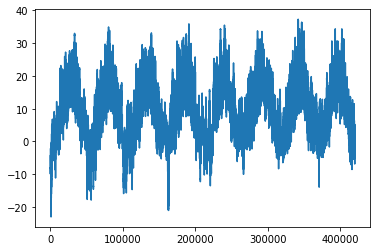

In [45]:
import matplotlib.pyplot as plt 
plt.plot(range(len(temperature)), temperature)
plt.show()

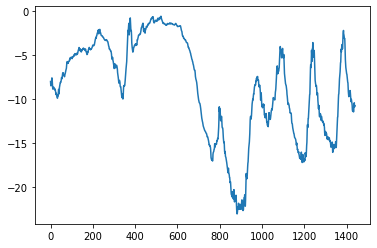

In [46]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**_What is periodicity?_**

Periodicity over multiple timescales in an important and very common
phenomenon of time series data.

Weather , mall parking, fitness tracker data, sales of a E-commerce site all have seasonality or periodicity over multiple time scales.

* train = 50% of the data
* validation = 25% of the data
* test = 25% of the data

In [47]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [48]:
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)


Number of training samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Preparing the data for Neural Networks ingestion.

### **_Normalization of the data_**


* But we need _Normalization_ in the first place?
  1. It is because the weather data have many variables which are not in the same scale. such as temperature in the celcius scale, humidity in the percentage scale, etc.
  2. So, we take the train data and calculate the mean and standard deviation of each variable.



In [49]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std 

print(mean)
print(std)

[ 988.74929466    8.82590329  282.9050718     4.31331863   75.87275476
   13.14569946    9.19414209    3.95148184    5.81050741    9.30208943
 1218.45204015    2.14977462    3.56048029  176.4405232 ]
[ 8.50510865  8.77098361  8.86560463  7.08011256 16.62877917  7.6012955
  4.14689697  4.76961017  2.63277288  4.1996886  42.0392747   1.53358803
  2.32305586 85.85032063]


In [50]:
from tensorflow import keras 

In [51]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


In [52]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

2022-04-15 22:38:56.068506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-15 22:38:56.068535: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 22:38:56.068555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux): /proc/driver/nvidia/version does not exist
2022-04-15 22:38:56.068791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
for samples, targets in train_dataset:
    print("Sample shape: ",samples.shape)
    print("Target shape: ",targets.shape)
    break

Sample shape:  (256, 120, 14)
Target shape:  (256,)


In [55]:
# computing common sense baseline MAE

def evaluate_naive_method(dataset):
    total_abs_err = 0
    sample_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        sample_seen += samples.shape[0]
    return total_abs_err / sample_seen

In [56]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.3f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.3f}")

Validation MAE: 2.442
Test MAE: 2.622


Training and evaluating a dense model.

In [57]:
from tensorflow.keras import layers

In [60]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("../models/checkpoints/jena_dense.keras", save_best_only=True)
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

In [61]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 40s 47ms/step - loss: 14.9646 - mae: 2.9907 - val_loss: 12.8076 - val_mae: 2.8201
Epoch 2/10
819/819 [==============================] - 36s 44ms/step - loss: 10.1048 - mae: 2.4975 - val_loss: 11.1104 - val_mae: 2.6298
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 9.1485 - mae: 2.3744 - val_loss: 10.9171 - val_mae: 2.6054
Epoch 4/10
819/819 [==============================] - 34s 41ms/step - loss: 8.5347 - mae: 2.2953 - val_loss: 10.3851 - val_mae: 2.5589
Epoch 5/10
819/819 [==============================] - 33s 40ms/step - loss: 8.1476 - mae: 2.2425 - val_loss: 10.3608 - val_mae: 2.5491
Epoch 6/10
819/819 [==============================] - 32s 39ms/step - loss: 7.8246 - mae: 2.1987 - val_loss: 10.6522 - val_mae: 2.5741
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 7.6114 - mae: 2.1716 - val_loss: 10.8067 - val_mae: 2.5963
Epoch 8/10
819/819 [==============================] -

In [63]:
model = keras.models.load_model("../models/checkpoints/jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 12s 28ms/step - loss: 11.3579 - mae: 2.6546
Test MAE: 2.65


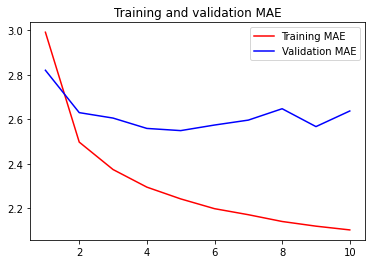

In [64]:
# plotting the performance for the model
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,color="red", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


1D Convolutional Model

In [65]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [66]:
callbacks = [
    keras.callbacks.ModelCheckpoint("../models/checkpoints/jena_conv.keras", save_best_only=True)
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

In [67]:
history = model.fit(train_dataset,
epochs=10,
validation_data=val_dataset,
callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 22.6753 - mae: 3.6999 - val_loss: 15.9138 - val_mae: 3.1827
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 15.6653 - mae: 3.1374 - val_loss: 15.1586 - val_mae: 3.0817
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 14.4912 - mae: 3.0174 - val_loss: 14.5848 - val_mae: 3.0075
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 13.6253 - mae: 2.9275 - val_loss: 15.3267 - val_mae: 3.0660
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 12.8972 - mae: 2.8441 - val_loss: 13.7723 - val_mae: 2.9397
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 12.2787 - mae: 2.7768 - val_loss: 14.4993 - val_mae: 2.9881
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 11.7558 - mae: 2.7137 - val_loss: 14.1373 - val_mae: 2.9586
Epoch 8/10
819/819 [============================

In [69]:
model = keras.models.load_model("../models/checkpoints/jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 14s 34ms/step - loss: 15.5623 - mae: 3.1166
Test MAE: 3.12


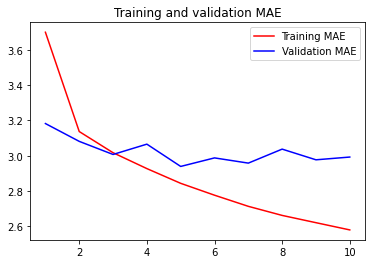

In [70]:
# plotting the performance for the model
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss,color="red", label="Training MAE")
plt.plot(epochs, val_loss, color="blue", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()